In [ ]:
import os
import gzip
import struct
import array
import numpy as np
from urllib.request import urlretrieve

import torch
from torch.utils.data import Dataset


BASE_URL = 'http://yann.lecun.com/exdb/mnist/'


# Helper functions and imports
def download(url, filename):
    if not os.path.exists('./data'):
        os.makedirs('./data')
    out_file = os.path.join('./data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def mnist():
    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(BASE_URL + filename, filename)

    train_images = parse_images('./data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('./data/train-labels-idx1-ubyte.gz')
    test_images  = parse_images('./data/t10k-images-idx3-ubyte.gz')
    test_labels  = parse_labels('./data/t10k-labels-idx1-ubyte.gz')
    return train_images, train_labels, test_images, test_labels


# Load and Prepare Data: Load the MNIST dataset, binarize the images, split into a training dataset
# of 10000 images and a test set of 10000 images.
def load_mnist():
    partial_flatten = lambda x : np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:,None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = partial_flatten(train_images) / 255.0
    test_images  = partial_flatten(test_images)  / 255.0
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]
    train_images = torch.from_numpy(np.round(train_images[0:10000])).float()
    train_labels = torch.from_numpy(train_labels[0:10000]).float()
    test_images = torch.from_numpy(np.round(test_images[0:10000])).float()
    test_labels = torch.from_numpy(test_labels[0:10000])
    return N_data, train_images, train_labels, test_images, test_labels


# Partition the training set into minibatches
def batch_indices(iter, num_batches, batch_size):
    # iter: iteration index
    # num_batches: number of batches
    # batch_size: batch size
    idx = iter % num_batches
    return slice(idx * batch_size, (idx+1) * batch_size)


# write a function to reshape 784 array into a 28x28 image for plotting
def array_to_image(array):
    return np.reshape(np.array(array), [28, 28])


# concatenate the images for plotting
def concat_images(images, row, col, padding = 3):
    result = np.zeros((28*row+(row-1)*padding,28*col+(col-1)*padding))
    for i in range(row):
        for j in range(col):
            result[i*28+(i*padding):i*28+(i*padding)+28, j*28+(j*padding):j*28+(j*padding)+28] = images[i+j*row]
    return result


class GANDataset(Dataset):
    def __init__(self, data_f, dev, transform=None):
        self.transform = transform
        self._load_data(data_f, dev)

    def _load_data(self, data_f, dev):
        with gzip.open(data_f, 'rb') as fid:
            head = fid.read(16)
            data = fid.read()

        res = struct.unpack(">iiii", head)
        data1 = struct.iter_unpack(">" + "B" * 784, data)

        self.d = torch.zeros(res[1], 1, res[2], res[3])
        for idx, k in enumerate(data1):
            tmp = torch.Tensor(k)
            tmp = tmp.view(1, res[2], res[3])
            if self.transform:
                tmp = self.transform(tmp)
            self.d[idx, :, :, :] = tmp

        self.d = self.d.to(dev)

    def __len__(self):
        return self.d.size()[0]

    def __getitem__(self, idx):
        return self.d[idx, :, :]

Epoch: 0, Iter: 0, ELBO:-548.4129028320312
Epoch: 1, Iter: 100, ELBO:-182.0055694580078
Epoch: 2, Iter: 200, ELBO:-178.5380096435547
Epoch: 3, Iter: 300, ELBO:-175.31761169433594
Epoch: 4, Iter: 400, ELBO:-173.33831787109375
Epoch: 5, Iter: 500, ELBO:-169.8173065185547
Epoch: 6, Iter: 600, ELBO:-167.0365447998047
Epoch: 7, Iter: 700, ELBO:-165.3115997314453
Epoch: 8, Iter: 800, ELBO:-163.4532012939453
Epoch: 9, Iter: 900, ELBO:-162.0281219482422
Epoch: 10, Iter: 1000, ELBO:-160.77239990234375
Epoch: 11, Iter: 1100, ELBO:-159.6454620361328
Epoch: 12, Iter: 1200, ELBO:-158.81666564941406
Epoch: 13, Iter: 1300, ELBO:-157.68927001953125
Epoch: 14, Iter: 1400, ELBO:-157.62933349609375
Epoch: 15, Iter: 1500, ELBO:-156.66494750976562
Epoch: 16, Iter: 1600, ELBO:-155.40748596191406
Epoch: 17, Iter: 1700, ELBO:-155.17710876464844
Epoch: 18, Iter: 1800, ELBO:-153.99887084960938
Epoch: 19, Iter: 1900, ELBO:-154.2928924560547
Epoch: 20, Iter: 2000, ELBO:-153.02545166015625
Epoch: 21, Iter: 2100, E

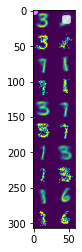

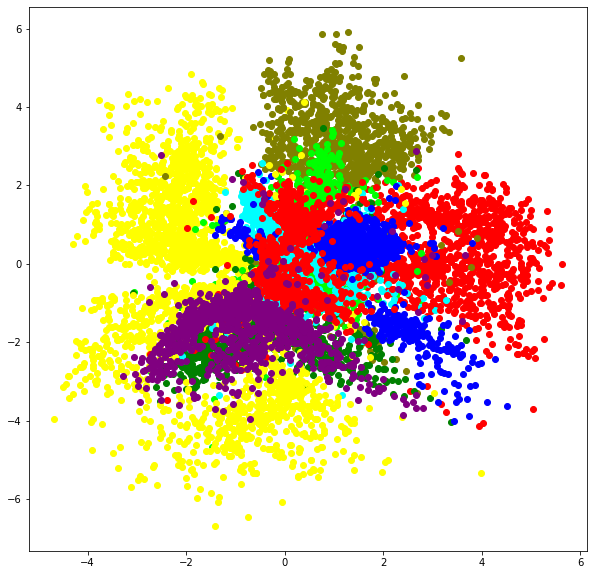

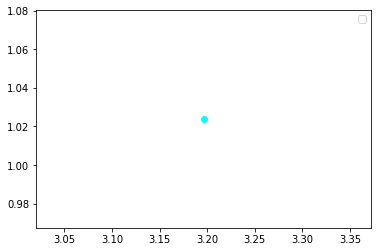

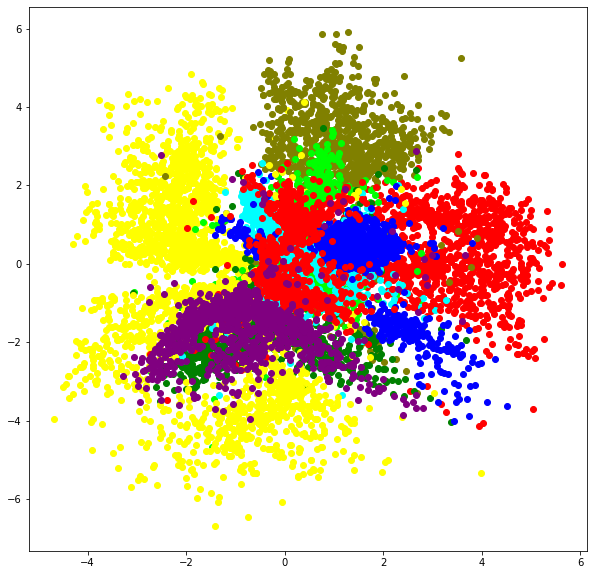

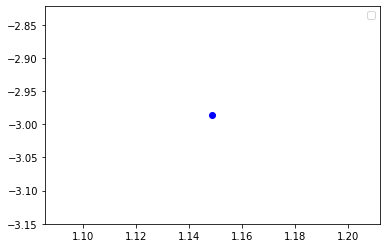

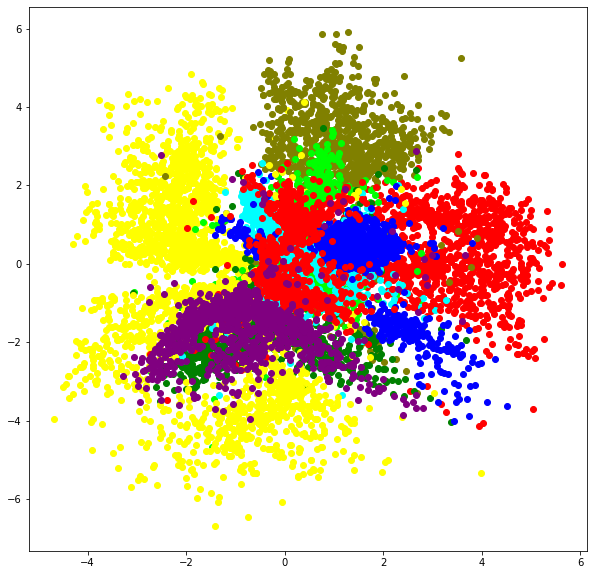

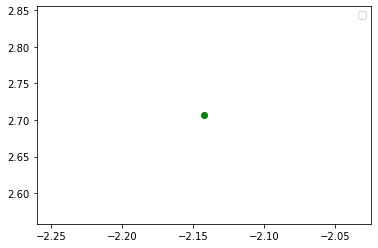

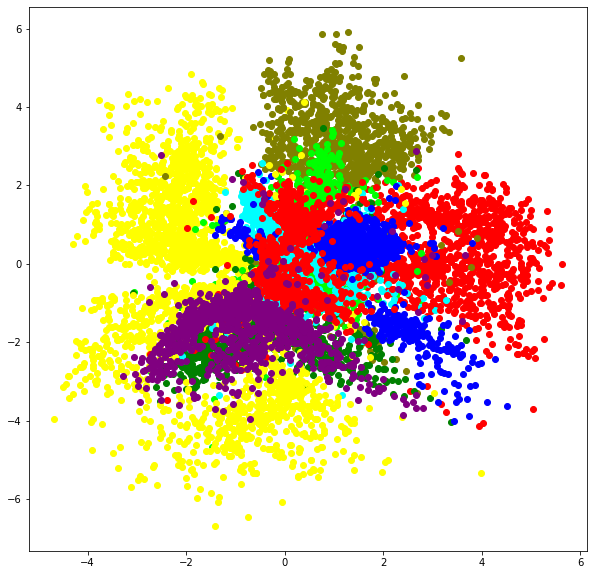

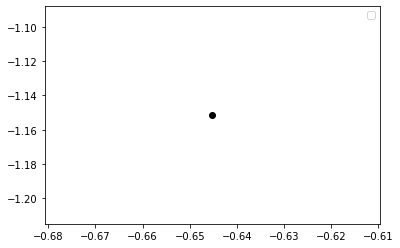

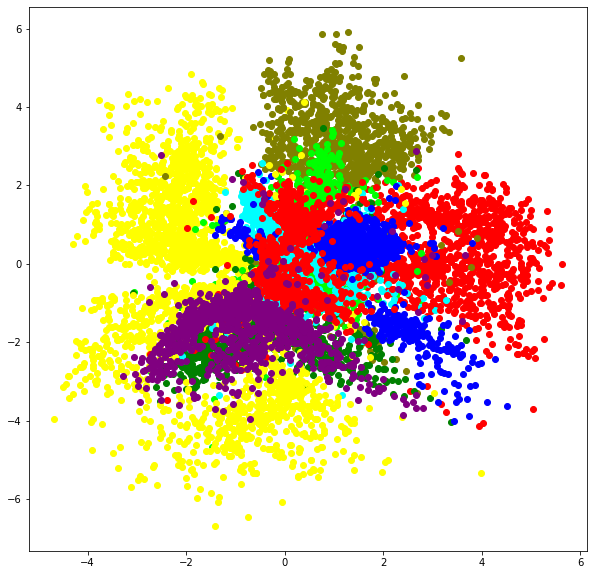

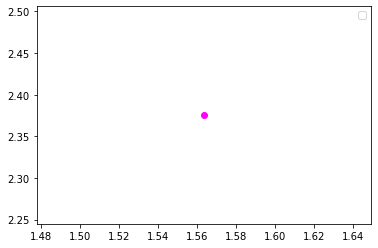

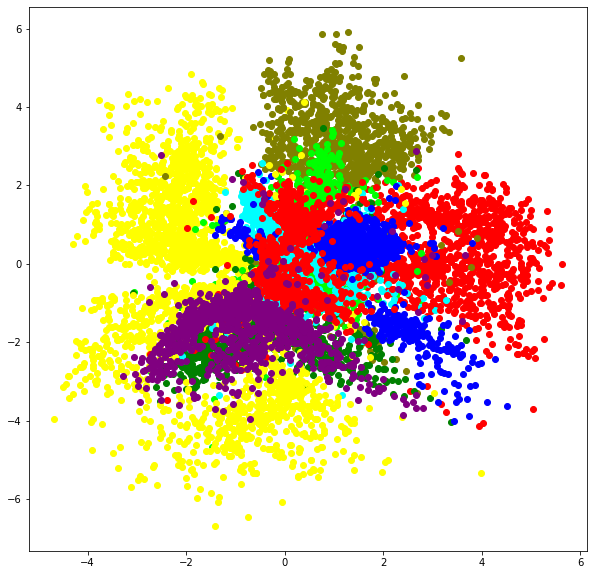

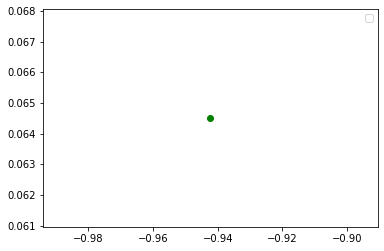

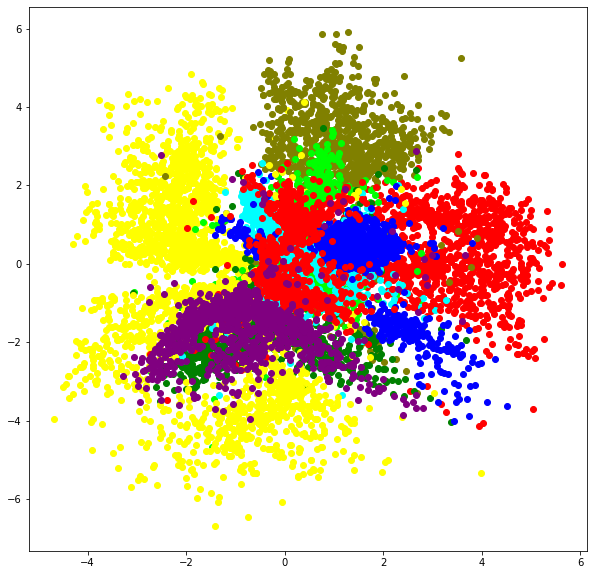

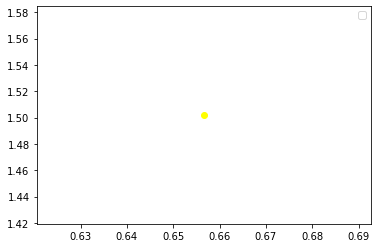

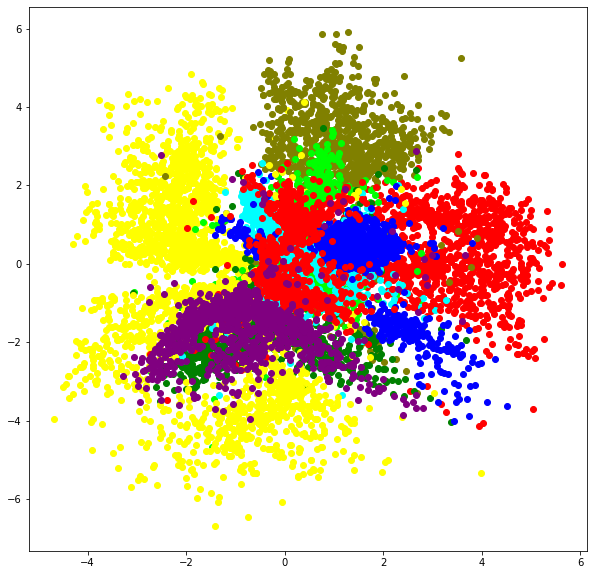

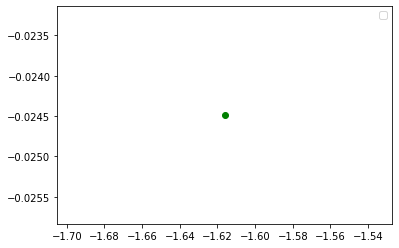

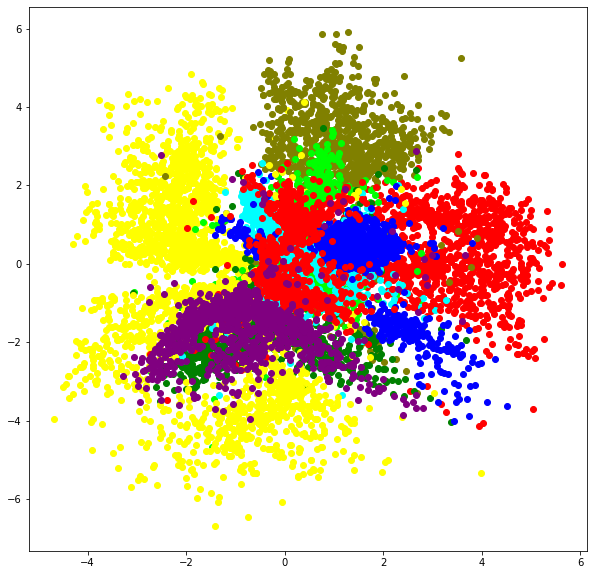

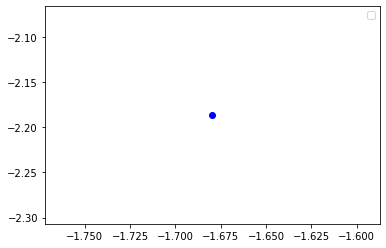

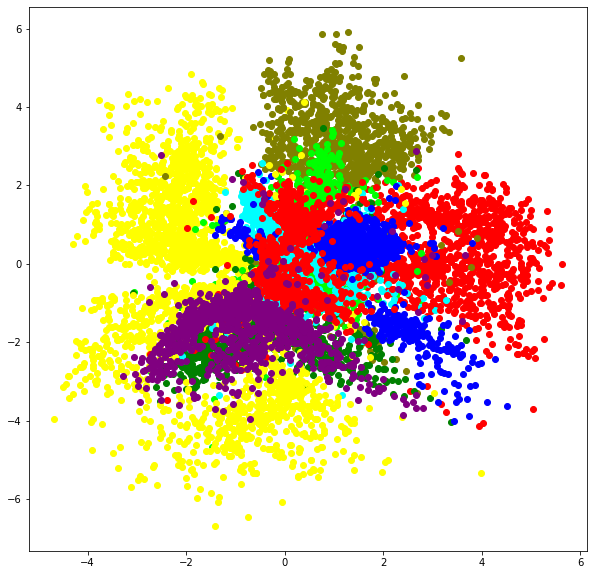

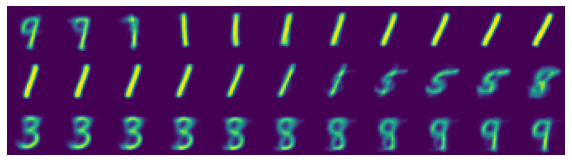

In [ ]:
import sys
import argparse
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
import matplotlib.image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
#from hw3_utils import array_to_image, concat_images, batch_indices, load_mnist




# The "encoder" model q(z|x)
class Encoder(nn.Module):
    def __init__(self, latent_dimension, hidden_units, data_dimension):
        super(Encoder, self).__init__()
        # Input:
        #   latent_dimension: the latent dimension of the encoder
        #   hidden_units: the number of hidden units

        self.fc1 = nn.Linear(data_dimension, hidden_units)
        self.fc2_mu = nn.Linear(hidden_units, latent_dimension)
        self.fc2_sigma = nn.Linear(hidden_units, latent_dimension)

    def forward(self, x):
        # Input: x input image [batch_size x data_dimension]
        # Output: parameters of a diagonal gaussian
        #   mean : [batch_size x latent_dimension]
        #   variance : [batch_size x latent_dimension]

        hidden = torch.tanh(self.fc1(x))
        mu = self.fc2_mu(hidden)
        log_sigma_square = self.fc2_sigma(hidden)
        sigma_square = torch.exp(log_sigma_square)
        return mu, sigma_square


# "decoder" Model p(x|z)
class Decoder(nn.Module):
    def __init__(self, latent_dimension, hidden_units, data_dimension):
        super(Decoder, self).__init__()
        # Input:
        #   latent_dimension: the latent dimension of the encoder
        #   hidden_units: the number of hidden units

        # TODO: deine the parameters of the decoder
        # fc1: a fully connected layer with 500 hidden units.
        # fc2: a fully connected layer with 500 hidden units.
        self.linear1=nn.Linear(latent_dimension,hidden_units)
        self.tan= nn.Tanh()
        self.linear2=nn.Linear(hidden_units,data_dimension)
        self.sig= nn.Sigmoid()

    def forward(self, z):
        # input
        #   z: latent codes sampled from the encoder [batch_size x latent_dimension]
        # output
        #   p: a tensor of the same size as the image indicating the probability of every pixel being 1 [batch_size x data_dimension]

        # TODO: implement the decoder here. The decoder is a multi-layer perceptron with two hidden layers.
        # The first layer is followed by a tanh non-linearity and the second layer by a sigmoid.
        p=self.tan(self.linear1(z))
        p=self.sig(self.linear2(p))

        return p


# VAE model
class VAE(nn.Module):
    def __init__(self, args):
        super(VAE, self).__init__()
        self.latent_dimension = args.latent_dimension
        self.hidden_units =  args.hidden_units
        self.data_dimension = args.data_dimension
        self.resume_training = args.resume_training
        self.batch_size = args.batch_size
        self.num_epoches = args.num_epoches
        self.e_path = args.e_path
        self.d_path = args.d_path

        # load and pre-process the data
        N_data, self.train_images, self.train_labels, test_images, test_labels = load_mnist()

        # Instantiate the encoder and decoder models
        self.encoder = Encoder(self.latent_dimension, self.hidden_units, self.data_dimension)
        self.decoder = Decoder(self.latent_dimension, self.hidden_units, self.data_dimension)

        # Load the trained model parameters
        if self.resume_training:
            self.encoder.load_state_dict(torch.load(self.e_path))
            self.decoder.load_state_dict(torch.load(self.d_path))

    # Sample from Diagonal Gaussian z~N(μ,σ^2 I)
    @staticmethod
    def sample_diagonal_gaussian(mu, sigma_square):
        # Inputs:
        #   mu: mean of the gaussian [batch_size x latent_dimension]
        #   sigma_square: variance of the gaussian [batch_size x latent_dimension]
        # Output:
        #   sample: from a diagonal gaussian with mean mu and variance sigma_square [batch_size x latent_dimension]

        # TODO: Implement the reparameterization trick and return the sample z [batch_size x latent_dimension]
        sample= (torch.randn(mu.size())*torch.sqrt(sigma_square))+mu
        return sample

    # Sampler from Bernoulli
    @staticmethod
    def sample_Bernoulli(p):
        # Input:
        #   p: the probability of pixels labeled 1 [batch_size x data_dimension]
        # Output:
        #   x: pixels'labels [batch_size x data_dimension], type should be torch.float32

        # TODO: Implement a sampler from a Bernoulli distribution
        x= (torch.rand_like(p)<p).float()
        return x


    # Compute Log-pdf of z under Diagonal Gaussian N(z|μ,σ^2 I)
    @staticmethod
    def logpdf_diagonal_gaussian(z, mu, sigma_square):
        # Input:
        #   z: sample [batch_size x latent_dimension]
        #   mu: mean of the gaussian distribution [batch_size x latent_dimension]
        #   sigma_square: variance of the gaussian distribution [batch_size x latent_dimension]
        # Output:
        #    logprob: log-probability of a diagomnal gaussian [batch_size]

        # TODO: implement the logpdf of a gaussian with mean mu and variance sigma_square*I
        sigma_log= -0.5*torch.log(sigma_square*2*torch.pi)
        sigma_inv= -0.5/sigma_square
        sam_dia= torch.pow((z-mu),2)*sigma_inv
        logprob= torch.sum(sigma_log+sam_dia,1)
        return logprob

    # Compute log-pdf of x under Bernoulli
    @staticmethod
    def logpdf_bernoulli(x, p):
        # Input:
        #   x: samples [batch_size x data_dimension]
        #   p: the probability of the x being labeled 1 (p is the output of the decoder) [batch_size x data_dimension]
        # Output:
        #   logprob: log-probability of a bernoulli distribution [batch_size]

        # TODO: implement the log likelihood of a bernoulli distribution p(x)
        x1= torch.log(p)*x
        x2= torch.log(1-p)*(1-x)
        logprob= torch.sum(x1+x2,1)
        return logprob

    # Sample z ~ q(z|x)
    def sample_z(self, mu, sigma_square):
        # input:
        #   mu: mean of the gaussian [batch_size x latent_dimension]
        #   sigma_square: variance of the gaussian [batch_size x latent_dimension]
        # Output:
        #   zs: samples from q(z|x) [batch_size x latent_dimension]
        zs = self.sample_diagonal_gaussian(mu, sigma_square)
        return zs


    # Variational Objective
    def elbo_loss(self, sampled_z, mu, sigma_square, x, p):
        # Inputs
        #   sampled_z: samples z from the encoder [batch_size x latent_dimension]
        #   mu:
        #   sigma_square: parameters of q(z|x) [batch_size x latent_dimension]
        #   x: data samples [batch_size x data_dimension]
        #   p: the probability of a pixel being labeled 1 [batch_size x data_dimension]
        # Output
        #   elbo: the ELBO loss (scalar)

        # log_q(z|x) logprobability of z under approximate posterior N(μ,σ)
        log_q = self.logpdf_diagonal_gaussian(sampled_z, mu, sigma_square)

        # log_p_z(z) log probability of z under prior
        z_mu = torch.FloatTensor([0]*self.latent_dimension).repeat(sampled_z.shape[0], 1)
        z_sigma = torch.FloatTensor([1]*self.latent_dimension).repeat(sampled_z.shape[0], 1)
        log_p_z = self.logpdf_diagonal_gaussian(sampled_z, z_mu, z_sigma)

        # log_p(x|z) - conditional probability of data given latents.
        log_p = self.logpdf_bernoulli(x, p)

        # TODO: implement the ELBO loss using log_q, log_p_z and log_p
        elbo= torch.mean(log_p_z+log_p-log_q)
        return elbo


    def train(self):

        # Set-up ADAM optimizer
        params = list(self.encoder.parameters()) + list(self.decoder.parameters())
        adam_optimizer = optim.Adam(params)

        # Train for ~200 epochs
        num_batches = int(np.ceil(len(self.train_images) / self.batch_size))
        num_iters = self.num_epoches * num_batches

        for i in range(num_iters):
            x_minibatch = self.train_images[batch_indices(i, num_batches, self.batch_size),:]
            adam_optimizer.zero_grad()

            mu, sigma_square = self.encoder(x_minibatch)
            zs = self.sample_z(mu, sigma_square)
            p = self.decoder(zs)
            elbo = self.elbo_loss(zs, mu, sigma_square, x_minibatch, p)
            total_loss = -elbo
            total_loss.backward()
            adam_optimizer.step()

            if i%100 == 0:
                print("Epoch: " + str(i//num_batches) + ", Iter: " + str(i) + ", ELBO:" + str(elbo.item()))

        # Save Optimized Model Parameters
        torch.save(self.encoder.state_dict(), self.e_path)
        torch.save(self.decoder.state_dict(), self.d_path)


    # Generate digits using the VAE
    def visualize_data_space(self):
        # TODO: Sample 10 z from prior
        torch.no_grad()

        image=[]
        for k in range(10):
          z1= torch.FloatTensor(np.zeros(self.latent_dimension))
          z2= torch.FloatTensor(np.ones(self.latent_dimension))
          z= self.sample_diagonal_gaussian(z1,z2)
          # TODO: For each z, plot p(x|z)
          dec_1= self.decoder(z).detach()
          dec_1=array_to_image(dec_1)
          image.append(dec_1)

          # TODO: Sample x from p(x|z)
          img= np.array(self.sample_Bernoulli(torch.tensor(dec_1)))
          image.append(img)
        # TODO: Concatenate plots into a figure (use the function concat_images
        concatenated_img=concat_images(image,10,2,padding=3)
        plt.imshow(concatenated_img)
        # TODO: Save the generated figure and include it in your report
        plt.savefig("Generated figure.png")


        # TODO: Concatenate plots into a figure (use the function concat_images)
       #plt.show(concat_images(10,2)
        # TODO: Save the generated figure and include it in your report
         #plt.savefig("Generated figure.png")


    # Produce a scatter plot in the latent space, where each point in the plot will be the mean vector
    # for the distribution $q(z|x)$ given by the encoder. Further, we will colour each point in the plot
    # by the class label for the input data. Each point in the plot is colored by the class label for
    # the input data.
    # The latent space should have learned to distinguish between elements from different classes, even though
    # we never provided class labels to the model!
    def visualize_latent_space(self):
      torch.no_grad()
      # TODO: Encode the training data self.train_images
      z5= self.encoder(self.train_images)
      color=["cyan","green","magenta","yellow","blue","violet","black","red","purple","black","olive","aqua"]
      for m in range(10):
        plt.scatter(z5[0][m,0].detach(),z5[0][m,1].detach(),c=color[np.argmax(np.array(self.train_labels[m]))])
        plt.legend()
        plt.show()

        # TODO: Take the mean vector of each encoding
        mu, sigma_square = self.encoder(self.train_images)

        mean = mu.detach().numpy()

        # TODO: Plot these mean vectors in the latent space with a scatter
        colours = ["Red", "Yellow", "Olive", "Lime", "Green",
                   "Aqua","Blue","Yellow", "Red", "Purple","Cyan","Black"]
        fig = plt.figure(figsize = (10,10))
        for i in range(10):
            sample_index = np.nonzero(self.train_labels.numpy()[:,i])[0]
            means1 = mean[sample_index]
            plt.scatter(means1[:,0], means1[:,1],c=colours[i])
        plt.show()

        # Colour each point depending on the class label


        # TODO: Save the generated figure and include it in your report



    # Function which gives linear interpolation z_α between za and zb
    @staticmethod
    def interpolate_mu(mua, mub, alpha = 0.5):
        return alpha*mua + (1-alpha)*mub


    # A common technique to assess latent representations is to interpolate between two points.
    # Here we will encode 3 pairs of data points with different classes.
    # Then we will linearly interpolate between the mean vectors of their encodings.
    # We will plot the generative distributions along the linear interpolation.
    def visualize_inter_class_interpolation(self):

        # TODO: Sample 3 pairs of data with different classes
        pairs = []
        while len(pairs) < 3:
            k1 = int(np.random.rand() * 10000)
            k2 = int(np.random.rand() * 10000)
            if not self.train_labels[k1].equal(self.train_labels[k2]):
                pairs.append([self.train_images[k1],self.train_images[k2]])

        # TODO: Encode the data in each pair, and take the mean vectors
        pairs_vectors = []
        for p in pairs:
            mu1, sigma_square1 = self.encoder(p[0])
            mu2, sigma_square2 = self.encoder(p[1])
            pairs_vectors.append([mu1,mu2])



        # TODO: Linearly interpolate between these mean vectors (Use the function interpolate_mu)
        z11 = []
        for alpha in np.arange(0,1.1,0.1):
            for p in pairs_vectors:
                z11.append(self.interpolate_mu(p[0],p[1],alpha))

        # TODO: Along the interpolation, plot the distributions p(x|z_α)
        plots = []
        for z in z11:
            p = self.decoder(z)
            plots.append(array_to_image(p.detach().numpy()))

        # Concatenate these plots into one figure
        required_plot = concat_images(plots, 3,11)
        fig = plt.figure(figsize = (10,10))
        plt.axis('off')
        plt.imshow(required_plot)
        return 0



def parse_args():
    parser = argparse.ArgumentParser(description=globals()['__doc__'])
    parser.add_argument('-f')
    parser.add_argument('--e_path', type=str, default="./e_params.pkl", help='Path to the encoder parameters.')
    parser.add_argument('--d_path', type=str, default="./d_params.pkl", help='Path to the decoder parameters.')
    parser.add_argument('--hidden_units', type=int, default=500, help='Number of hidden units of the encoder and decoder models.')
    parser.add_argument('--latent_dimension', type=int, default='2', help='Dimensionality of the latent space.')
    parser.add_argument('--data_dimension', type=int, default='784', help='Dimensionality of the data space.')
    parser.add_argument('--resume_training', action='store_true', help='Whether to resume training')
    parser.add_argument('--seed', type=int, default=1234, help='Random seed')
    parser.add_argument('--num_epoches', type=int, default=200, help='Number of epochs for training.')
    parser.add_argument('--batch_size', type=int, default=100, help='Batch size.')

    args = parser.parse_args()
    return args


def main():

    # read the function arguments
    args = parse_args()

    # set the random seed
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)

    # train the model
    vae = VAE(args)
    vae.train()

    # visualize the latent space
    vae.visualize_data_space()
    vae.visualize_latent_space()
    vae.visualize_inter_class_interpolation()

main()